# Making deep neural networks efficient

In [ ]:
!pip3 install torchscan
!pip3 install torch-simplify
from __future__ import print_function
import argparse
import torch
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchscan
from simplify import remove_zeroed

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class my_neural_network(torch.nn.Module):
    def __init__(self):
        super(my_neural_network, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def test(model, test_loader, epoch):
  tk0 = tqdm(test_loader, total=int(len(test_loader)), desc="TEST epoch {}".format(epoch))
  mean_error = AverageMeter("error")
  model.eval()#necessary if using layers like dropout/batchnorm
  with torch.no_grad():#no store of the forward intermediate results
    for batch_idx, (data, target) in enumerate(tk0):
          data = data.to(device)
          target = target.to(device)
          #data = torch.flatten(data, start_dim=1)
          y = model(data)#forward is called implicitly
          _, mmax = torch.max(y, 1)
          this_error = torch.mean((mmax != target)*100.0)
          mean_error.update(this_error)
          tk0.set_postfix(error = mean_error.avg.item())
  return mean_error.avg.item()

def validate(model, val_loader, loss, epoch):
  tk0 = tqdm(test_loader, total=int(len(test_loader)), desc="VALIDATION epoch {}".format(epoch), disable = True)
  mean_loss = AverageMeter("loss")
  mean_error = AverageMeter("error")
  model.eval()#necessary if using layers like dropout/batchnorm
  with torch.no_grad():#no store of the forward intermediate results
    for batch_idx, (data, target) in enumerate(tk0):
          data = data.to(device)
          target = target.to(device)
          #data = torch.flatten(data, start_dim=1)
          y = model(data)#forward is called implicitly
          this_loss = loss(y, target)
          mean_loss.update(this_loss)
          this_error = torch.mean((y.argmax(dim=1) != target)*100.0)
          mean_error.update(this_error)
          tk0.set_postfix(loss = mean_loss.avg.item())
  return mean_loss.avg.item(), mean_error.avg.item()

In [ ]:
def train(model, train_loader, optimizer, loss, epoch):
  model.train()
  mean_loss = AverageMeter("loss")
  mean_error = AverageMeter("error")
  tk0 = tqdm(train_loader, total=int(len(train_loader)), desc="TRAIN epoch {}".format(epoch))
  for batch_idx, (data, target) in enumerate(tk0):
        data = data.to(device)
        target = target.to(device)
        #data = torch.flatten(data, start_dim=1)--no need if we use conv layers!
        y = model(data)
        this_loss = loss(y, target)
        mean_loss.update(this_loss)
        this_error = torch.mean((y.argmax(dim=1) != target)*100.0)
        mean_error.update(this_error)
        optimizer.zero_grad()#zero_gradient(model.get_layers_pointer())
        this_loss.backward()#model.backward(y_hat)
        optimizer.step()#gradient_descent(model.get_layers_pointer(), eta)
        tk0.set_postfix(loss=this_loss.item(), error = this_error.item())
  return mean_loss.avg.item(), mean_error.avg.item()

In [ ]:
  import torch
  from torchvision import datasets, transforms
  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
  dataset1 = datasets.MNIST('../data', train=True, download=True,
                      transform=transform)
  dataset2 = datasets.MNIST('../data', train=False,
                      transform=transform)
  validation_ratio = 0.9
  validation_size = int(validation_ratio*len(dataset1))
  train_dataset, val_dataset = torch.utils.data.random_split(dataset1, [len(dataset1) - validation_size, validation_size])
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1000, shuffle = True)
  test_loader = torch.utils.data.DataLoader(dataset2, batch_size = 1000, shuffle = False)

## Main program

Create and train a simple network to recognize handwritten digits based on MNIST data.

We use 30 neurons in the intermediate layer and with the learning rate of 3.0, mini-batch size of 10, the network should achieve about 95% accuracy in 15 epochs. 

In [ ]:
import numpy as np
class plateau_identifier():
  def __init__(self, action, patience = 1):
    self.patience = patience
    self.action = action
    self.accumulated_epochs = 0
    self.best_val = np.Inf
  def step(self, model, this_loss, args):
    if this_loss < self.best_val:
      self.best_val = this_loss
      self.accumulated_epochs = 0
      return True
    else:
      self.accumulated_epochs += 1
      if self.accumulated_epochs >= self.patience:
        print("PLATEAU IDENTIFIED!")
        self.action(model)
        self.accumulated_epochs = 0
        self.best_val = np.Inf
        args.best_achieved.append([100.0, np.Inf])
      return False

In [ ]:
import torch.nn.utils.prune as prune
def prune_model(model, amount=0.2):
  for name, module in model.named_modules():    
    if ("conv" in name) or ("fc" in name):
        #prune.l1_unstructured(module, name='weight', amount=amount)
        prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)

def get_parameters_num(model):
  total_params = 0
  surviving_params = 0
  for name, module in model.named_modules():    
    if ("conv" in name) or ("fc" in name):
      surviving_params += torch.sum(dict(module.named_buffers())['weight_mask']).item()
      total_params += module.weight.numel()
  return 100.0 * surviving_params / total_params

In [ ]:
##PLOT UTILITY FUNCTIONS
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

class logger():
  def __init__(self):
    self.train_loss = []
    self.val_loss = []
    self.train_error = []
    self.val_error = []
    self.total_parameters = []
    self.best_achieved = []
    self.best_achieved.append([100.0, np.Inf])

def plotting(args):
  clear_output(wait=True)
  plt.figure(1)
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.plot(range(1, len(args.train_loss)+1), args.train_loss, label='train')
  plt.plot(range(1, len(args.val_loss)+1), args.val_loss, label='val')
  plt.legend()
  plt.show()
  plt.figure(2)
  plt.xlabel("epochs")
  plt.ylabel("error [%]")
  plt.plot(range(1, len(args.train_error)+1), args.train_error, label='train')
  plt.plot(range(1, len(args.val_error)+1), args.val_error, label='val')
  plt.legend()
  plt.show()
  plt.figure(3)
  plt.xlabel("parameters [%]")
  plt.ylabel("Test set error achieved [%]")
  these_data = np.vstack(args.best_achieved)
  plt.scatter(these_data[:, 0], these_data[:, 1])
  plt.legend()
  plt.show()


In [ ]:
model = my_neural_network().to(device)

args = logger()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss = torch.nn.CrossEntropyLoss().to(device)

plateau_scheduler = plateau_identifier(prune_model, patience = 2)
prune_model(model, amount=0.0)

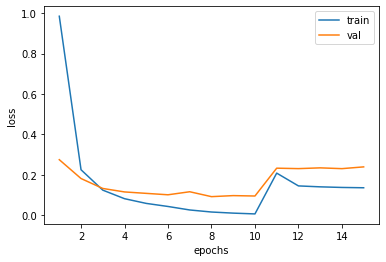

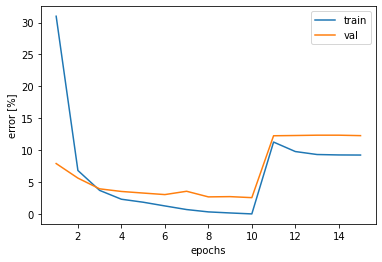

No handles with labels found to put in legend.


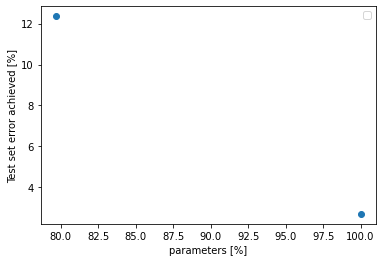

TEST epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# hyper parameters
epochs = 15

for epoch in range(1, epochs + 1):
  this_train_loss, this_train_error = train(model, train_loader, optimizer, loss, epoch)
  args.train_loss.append(this_train_loss)
  args.train_error.append(this_train_error)
  this_val_loss, this_val_error = validate(model, val_loader, loss, epoch)
  args.val_loss.append(this_val_loss)
  args.val_error.append(this_val_error)
  new_best = plateau_scheduler.step(model, args.val_loss[-1], args)
  args.total_parameters.append(get_parameters_num(model))
  if epoch != 1:
    plotting(args)

  test_error = test(model, test_loader, epoch)
  if new_best:
    args.best_achieved[-1] = (args.total_parameters[-1], test_error)
    torch.save(model.state_dict(), str(args.best_achieved[-1][0])+'.pt')
  

### Training on GPU

...

In [ ]:
def finalize_pruning(model):
  prune.remove(model.conv1, 'weight')
  prune.remove(model.conv2, 'weight')
  prune.remove(model.fc1, 'weight')
  prune.remove(model.fc2, 'weight')

finalize_pruning(model)#beware! this function does not remove anything physically, it just flushes the masks to the weights of the model!

In [ ]:
torchscan.summary(model, (1,28,28))

__________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #        
my_neural_network            my_neural_network     (-1, 10)                  0              
├─conv1                      Conv2d                (-1, 32, 26, 26)          320            
├─conv2                      Conv2d                (-1, 64, 24, 24)          18,496         
├─fc1                        Linear                (-1, 128)                 1,179,776      
├─fc2                        Linear                (-1, 10)                  1,290          
Trainable params: 1,199,882
Non-trainable params: 0
Total params: 1,199,882
------------------------------------------------------------------------------------------
Model size (params + buffers): 4.58 Mb
Framework & CUDA overhead: 0.00 Mb
Total RAM usage: 4.58 Mb
-------------------------------------------------------------------------------------

In [ ]:
#Here the simplify library is called to make the gain!
remove_zeroed(model, torch.zeros((1,1,28,28), device=device), [])

my_neural_network(
  (conv1): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(26, 51, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7344, out_features=102, bias=True)
  (fc2): Linear(in_features=102, out_features=8, bias=True)
)

In [ ]:
torchscan.summary(model, (1,28,28))

__________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #        
my_neural_network            my_neural_network     (-1, 8)                   0              
├─conv1                      Conv2d                (-1, 26, 26, 26)          260            
├─conv2                      Conv2d                (-1, 51, 24, 24)          11,985         
├─fc1                        Linear                (-1, 102)                 749,190        
├─fc2                        Linear                (-1, 8)                   824            
Trainable params: 762,259
Non-trainable params: 0
Total params: 762,259
------------------------------------------------------------------------------------------
Model size (params + buffers): 2.91 Mb
Framework & CUDA overhead: 0.00 Mb
Total RAM usage: 2.91 Mb
-----------------------------------------------------------------------------------------

## Post Training Quantization
To further enhance the performance (in terms of resource usage) you can post-hoc quantize the model using the following recipe.
Then, you can evaluate if any advantage is achieved looking at the average inference time (as the working frequency is constant, less/faster operations result in lower time to perform the feed-forward step!).

Remember to test and to quantize on CPU!

More details on this (and beyond!) at https://pytorch.org/docs/stable/torch.quantization.html 

In [ ]:
backend = "fbgemm"
qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_static_quantized = torch.quantization.prepare(torch.quantization.QuantWrapper(model), inplace=False)#Quantwrapper limits where the parameters and the activations are quantized!
input_fp32 = torch.randn(100,1,28,28)#necessary for calibration
model_static_quantized(input_fp32)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)#the real conversion

model_static_quantized(input_fp32)#example of inference with the quantized model

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/quantize.py:251: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


tensor([[-4.3328e+00,  2.2871e+00,  4.2984e-01, -4.9386e+00, -5.3865e-03,
         -1.9764e+00, -2.7013e+00, -4.9744e+00],
        [-4.6557e+00, -3.1251e+00, -7.4385e-01, -3.4397e+00,  1.5049e-01,
         -2.3092e+00, -1.2932e+00, -7.0456e+00],
        [-7.0969e+00,  4.1265e+00,  2.1378e-01, -6.3513e+00, -8.0147e-01,
         -2.4850e+00, -4.4317e+00, -6.9962e+00],
        [-5.0994e+00, -2.8528e+00,  8.5154e-01, -2.4678e+00,  1.9121e+00,
         -2.0147e+00, -1.5298e+00, -4.0361e+00],
        [-7.0020e+00, -9.2543e-01, -7.3741e-01, -5.8178e+00,  2.2908e+00,
         -1.6034e+00, -2.3446e+00, -6.7242e+00],
        [-7.0698e+00,  1.5910e-01, -2.3761e+00, -5.1899e+00,  3.1917e-01,
         -3.0276e+00, -3.7657e+00, -6.2550e+00],
        [-6.8295e+00, -1.5755e-01, -4.4267e-01, -6.0612e+00,  3.3066e-01,
         -1.2182e+00, -2.9684e+00, -6.9219e+00],
        [-6.2333e+00,  1.0264e+00,  1.9085e+00, -4.0215e+00, -1.0860e+00,
         -2.2299e+00, -1.5276e+00, -2.5600e+00],
        [-4.7146

In [ ]:
test(model, test_loader, -1)
test(model_static_quantized, test_loader, -1)

TEST epoch -1:   0%|          | 0/10 [00:00<?, ?it/s]

TEST epoch -1:   0%|          | 0/10 [00:00<?, ?it/s]

98.86000061035156